# Semi-Supervised Conditional GAN (SCGAN)

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import json

from keras import backend as K

from keras.datasets import mnist
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Dropout, Flatten, Input, Lambda, Reshape, Embedding,
                          Multiply)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical

## Dataset

In [0]:
class Dataset:
    def __init__(self, num_labeled):

        # Number labeled examples to use for training
        self.num_labeled = num_labeled

        # Load the MNIST dataset
        (self.x_train, self.y_train), (self.x_test,
                                       self.y_test) = mnist.load_data()

        def preprocess_imgs(x):
            # Rescale [0, 255] grayscale pixel values to [-1, 1]
            x = (x.astype(np.float32) - 127.5) / 127.5
            # Expand image dimensions to width x height x channels
            x = np.expand_dims(x, axis=3)
            return x

        def preprocess_labels(y):
            return y.reshape(-1, 1)

        # Training data
        self.x_train = preprocess_imgs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)

        # Testing data
        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)

    def batch_labeled(self, batch_size):
        # Get a random batch of labeled images and their labels
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels

    def batch_unlabeled(self, batch_size):
        # Get a random batch of unlabeled images
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0],
                                batch_size)
        imgs = self.x_train[idx]
        return imgs

    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train

    def test_set(self):
        return self.x_test, self.y_test

In [0]:
# Number of labeled examples to use (rest will be used as unlabeled)
num_labeled = 1000

dataset = Dataset(num_labeled)

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


# Semi-Supervied GAN

In [0]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Number of classes in the dataset
num_classes = 10

## Generator

In [0]:
def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # Output layer with tanh activation
    model.add(Activation('tanh'))
    
    z = Input(shape=(z_dim, ))
    label = Input(shape=(num_classes, ), dtype='float32')
    label_embedding = Dense(z_dim, input_dim=num_classes)(label)
    print(label_embedding)
    joined_representation = Multiply()([z, label_embedding])
    print(joined_representation)
    conditioned_img = model(joined_representation)

    model = Model([z, label], conditioned_img)

    return model

In [0]:
build_generator(z_dim).summary()

Tensor("dense_13/BiasAdd:0", shape=(?, 100), dtype=float32)
Tensor("multiply_7/mul:0", shape=(?, 100), dtype=float32)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 100)          1100        input_18[0][0]                   
__________________________________________________________________________________________________
multiply_7 (Multiply)           (None, 100)          0           input_17

## Discriminator

In [0]:
def build_discriminator_net(img_shape):

    model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x32 tensor
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Droupout
    model.add(Dropout(0.5))

    # Flatten the tensor
    model.add(Flatten())

    # Fully connected layer with num_classes neurons
    model.add(Dense(num_classes))

    return model

In [0]:
def build_discriminator_supervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    # Softmax activation, giving predicted probability distribution over the real classes
    model.add(Activation('softmax'))

    return model

In [0]:
def build_discriminator_unsupervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    def predict(x):
        # Transform distribution over real classes into a binary real-vs-fake probability
        prediction = 1.0 - (1.0 /
                            (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction

    # 'Real-vs-fake' output neuron defined above
    model.add(Lambda(predict))

    return model

## Build the Model

In [0]:
def build_gan(generator, discriminator):

#     model = Sequential()

    # Combined Generator -> Discriminator model
#     model.add(generator)
#     model.add(discriminator)
    
    z = Input(shape=(z_dim, ))
    label = Input(shape=(num_classes, ))
    img = generator([z, label])
    output = discriminator(img)
    model = Model([z, label], output)

    return model

In [158]:
generator = build_generator(z_dim)
discriminator_unsupervised.trainable = False
gan = build_gan(generator, discriminator_unsupervised)
gan.summary()
gan.compile(loss='binary_crossentropy', optimizer=Adam())

Tensor("dense_28/BiasAdd:0", shape=(?, 100), dtype=float32)
Tensor("multiply_13/mul:0", shape=(?, 100), dtype=float32)
Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_42 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
model_16 (Model)                (None, 28, 28, 1)    1638221     input_41[0][0]                   
                                                                 input_42[0][0]                   
_______________________________________________________________________

### Discriminator

In [0]:
# Core Discriminator network:
# These layers are shared during supervised and unsupervised training
discriminator_net = build_discriminator_net(img_shape)

# Build & compile the Discriminator for supervised training
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss='categorical_crossentropy',
                                 metrics=['accuracy'],
                                 optimizer=Adam())

# Build & compile the Discriminator for unsupervised training
discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss='binary_crossentropy',
                                   optimizer=Adam())

### Generator

In [160]:
# Build the Generator
generator = build_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator_unsupervised.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
# Note that we are using the Discriminator version with unsupervised output
gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

Tensor("dense_31/BiasAdd:0", shape=(?, 100), dtype=float32)
Tensor("multiply_14/mul:0", shape=(?, 100), dtype=float32)


## Training

In [0]:
%mkdir models/models-label-1000
%mkdir losses/losses-label-1000

In [0]:
supervised_losses = []
unsupervised_losses = []
g_losses = []
iteration_checkpoints = []


def train(iterations, batch_size, save_interval):

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get labeled examples
        imgs, labels = dataset.batch_labeled(batch_size)

        # One-hot encode labels
        labels = to_categorical(labels, num_classes=num_classes)

        # Get unlabeled examples
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        fake_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        fake_labels = to_categorical(fake_labels, num_classes=num_classes)
        gen_imgs = generator.predict([z, fake_labels])

        # Train on real labeled examples
        d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)

        # Train on real unlabeled examples
        d_loss_real = discriminator_unsupervised.train_on_batch(imgs_unlabeled, real)

        # Train on fake examples
        d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)

        d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict([z, labels])

        # Train Generator
        g_loss = gan.train_on_batch([z,labels], np.ones((batch_size, 1)))

        if (iteration + 1) % save_interval == 0:

            # Save Discriminator supervised classification loss to be plotted after training
            supervised_losses.append(d_loss_supervised)
            unsupervised_losses.append(d_loss_unsupervised)
            g_losses.append(g_loss)
            
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print(
                "%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]"
                % (iteration + 1, d_loss_supervised, 100 * accuracy,
                   d_loss_unsupervised, g_loss))
            
            discriminator_supervised.save("./models/models-label-" + str(num_labeled) + "/discriminator_supervised-" + str(iteration+1) + ".h5")
            file1 = "./losses/losses-label-" + str(num_labeled) + "/supervised_losses.json"
            file2 = "./losses/losses-label-" + str(num_labeled) + "/unsupervised_losses.json"
            file3 = "./losses/losses-label-" + str(num_labeled) + "/g_losses.json"
            with open(file1, 'w') as json_file:
                  json.dump(str(supervised_losses), json_file)
            with open(file2, 'w') as json_file:
                  json.dump(str(unsupervised_losses), json_file)
            with open(file3, 'w') as json_file:
                  json.dump(str(g_losses), json_file)

## Train the Model and Inspect Output

Note that the `'Discrepancy between trainable weights and collected trainable'` warning from Keras is expected. It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

In [163]:
# Set hyperparameters
iterations = 8000
batch_size = 32
save_interval = 100

# Train the SGAN for the specified number of iterations
train(iterations, batch_size, save_interval)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100 [D loss supervised: 0.3104, acc.: 90.62%] [D loss unsupervised: 0.0118] [G loss: 3.182050]
200 [D loss supervised: 0.0557, acc.: 100.00%] [D loss unsupervised: 0.0223] [G loss: 1.475410]
300 [D loss supervised: 0.1232, acc.: 93.75%] [D loss unsupervised: 0.0705] [G loss: 3.847853]
400 [D loss supervised: 0.0846, acc.: 96.88%] [D loss unsupervised: 0.0909] [G loss: 5.216974]
500 [D loss supervised: 0.0548, acc.: 96.88%] [D loss unsupervised: 0.0396] [G loss: 5.483150]
600 [D loss supervised: 0.0466, acc.: 100.00%] [D loss unsupervised: 0.0803] [G loss: 4.546072]
700 [D loss supervised: 0.0094, acc.: 100.00%] [D loss unsupervised: 0.0798] [G loss: 5.646016]
800 [D loss supervised: 0.0306, acc.: 100.00%] [D loss unsupervised: 0.1260] [G loss: 4.947357]
900 [D loss supervised: 0.0329, acc.: 100.00%] [D loss unsupervised: 0.2130] [G loss: 3.595466]
1000 [D loss supervised: 0.0206, acc.: 100.00%] [D loss unsupervised: 0.4399] [G loss: 2.534733]
1100 [D loss supervised: 0.0072, acc.: 100.

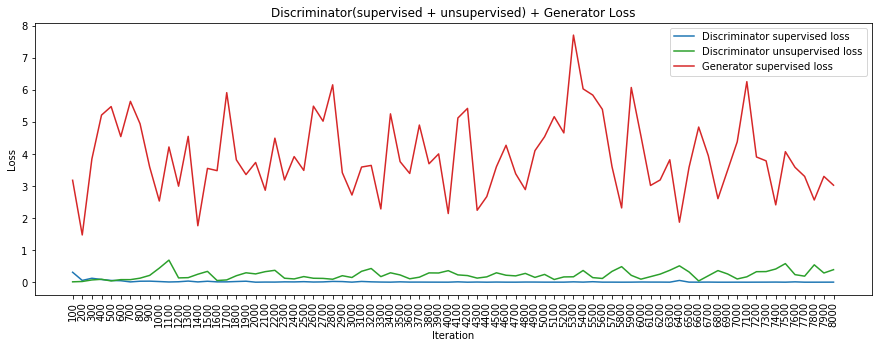

In [164]:
supervised_losses = np.array(supervised_losses)
unsupervised_losses = np.array(unsupervised_losses)
g_losses = np.array(g_losses)

# Plot Discriminator supervised loss
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, supervised_losses, label="Discriminator supervised loss", color='tab:blue')
plt.plot(iteration_checkpoints, unsupervised_losses, label="Discriminator unsupervised loss", color='tab:green')
plt.plot(iteration_checkpoints, g_losses, label="Generator supervised loss", color='tab:red')

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Discriminator(supervised + unsupervised) + Generator Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

In [165]:
print(supervised_losses[-10:])

[0.00052179 0.00153511 0.00225196 0.00394122 0.00064216 0.01090027
 0.00055001 0.00069199 0.00110341 0.00206788]


## SGAN Classifier – Training and Test Accuracy 

In [166]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the training set
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

1000/1000 [==============================] - 1s 1ms/step
Training Accuracy: 100.00%


In [167]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the test set
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

10000/10000 [==============================] - 1s 73us/step
Test Accuracy: 96.24%


# Fully-Supervised Classifier

In [0]:
# Fully supervised classifier with the same network architecture as the SGAN Discriminator
mnist_classifier = build_discriminator_supervised(build_discriminator_net(img_shape))
mnist_classifier.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

In [169]:
imgs, labels = dataset.training_set()
imgs = imgs[:num_labeled]
labels = labels[:num_labeled]

# One-hot encode labels
labels = to_categorical(labels, num_classes=num_classes)

# Train the classifier
training = mnist_classifier.fit(x=imgs,
                                y=labels,
                                batch_size=32,
                                epochs=200,
                                verbose=1)
losses = training.history['loss']
accuracies = training.history['acc']

Epoch 1/200
1000/1000 [==============================] - 4s 4ms/step - loss: 1.3372 - acc: 0.5830
Epoch 2/200
1000/1000 [==============================] - 0s 190us/step - loss: 0.4793 - acc: 0.8520
Epoch 3/200
1000/1000 [==============================] - 0s 189us/step - loss: 0.2742 - acc: 0.9170
Epoch 4/200
1000/1000 [==============================] - 0s 180us/step - loss: 0.1937 - acc: 0.9450
Epoch 5/200
1000/1000 [==============================] - 0s 205us/step - loss: 0.1405 - acc: 0.9610
Epoch 6/200
1000/1000 [==============================] - 0s 190us/step - loss: 0.1003 - acc: 0.9780
Epoch 7/200
1000/1000 [==============================] - 0s 187us/step - loss: 0.0742 - acc: 0.9820
Epoch 8/200
1000/1000 [==============================] - 0s 182us/step - loss: 0.0434 - acc: 0.9900
Epoch 9/200
1000/1000 [==============================] - 0s 186us/step - loss: 0.0370 - acc: 0.9940
Epoch 10/200
1000/1000 [==============================] - 0s 194us/step - loss: 0.0269 - acc: 0.9970
E

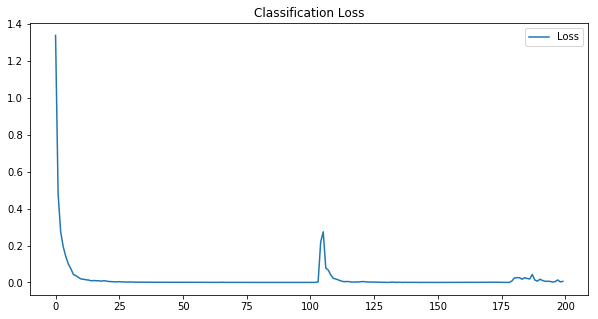

In [170]:
# Plot classification loss
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses), label="Loss")
plt.title("Classification Loss")
plt.legend()

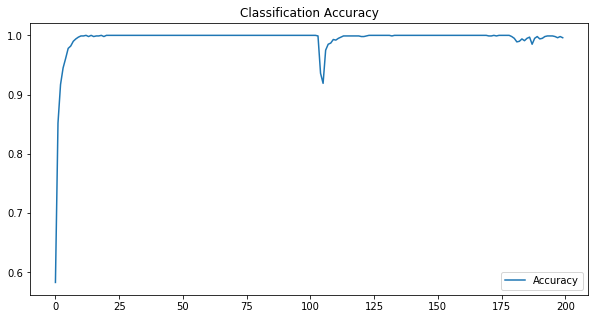

In [171]:
# Plot classification accuracy
plt.figure(figsize=(10, 5))
plt.plot(np.array(accuracies), label="Accuracy")
plt.title("Classification Accuracy")
plt.legend()

In [172]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the training set
_, accuracy = mnist_classifier.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

1000/1000 [==============================] - 2s 2ms/step
Training Accuracy: 100.00%


In [173]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the test set
_, accuracy = mnist_classifier.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

10000/10000 [==============================] - 1s 74us/step
Test Accuracy: 93.21%


---